# Task 2: Adjacency Matrix of a Graph

In this notebook, we'll work with a "friendship graph" between users, represented as an adjacency matrix A of size N×N. We'll cover:

1. Creating the adjacency matrix
2. Calculating vertex degrees
3. Computing the matrix of paths of length 2
4. Finding indirect friends
5. Analyzing eigenvalues

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

np.random.seed(42)

## 1. Creating the Matrix

We'll generate a random adjacency matrix A for N=6 users, where:
- A[i, j] = 1 if there is a connection between users i and j
- A[i, j] = 0 otherwise

We'll then make the graph undirected by ensuring the matrix is symmetric.

Initial (directed) adjacency matrix:
[[0 0 1 0 0 1]
 [0 0 1 0 0 1]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [1 1 1 0 0 0]
 [1 0 0 0 0 0]]

 Transpose
[[0 0 0 0 1 1]
 [0 0 1 0 1 0]
 [1 1 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 1 0 0 0 0]]

Undirected adjacency matrix:
[[0 0 1 0 1 1]
 [0 0 1 0 1 1]
 [1 1 0 0 1 0]
 [0 0 0 0 1 0]
 [1 1 1 1 0 0]
 [1 1 0 0 0 0]]

Is the matrix symmetric? True


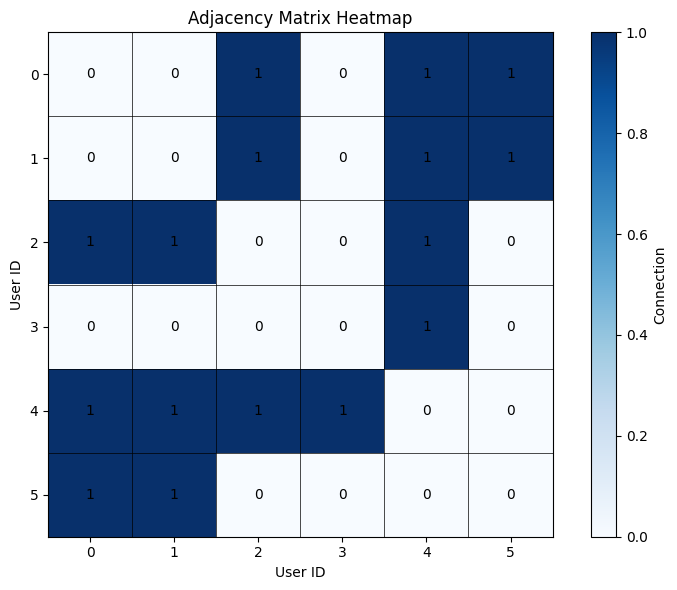

In [ ]:
N = 6
connection_probability = 0.3
A = (np.random.random((N, N)) < connection_probability).astype(int)
np.fill_diagonal(A, 0)
print("Initial (directed) adjacency matrix:")
print(A)
print("\n Transpose")
print(A.T)
A_undirected = np.logical_or(A, A.T).astype(int)
print("\nUndirected adjacency matrix:")
print(A_undirected)
print(f"\nIs the matrix symmetric? {np.allclose(A_undirected, A_undirected.T)}")
plt.figure(figsize=(8, 6))
plt.imshow(A_undirected, cmap='Blues')
plt.colorbar(label='Connection')
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('User ID')
plt.ylabel('User ID')
for i in range(N):
    plt.axhline(i-0.5, color='black', linewidth=0.5)
    plt.axvline(i-0.5, color='black', linewidth=0.5)
for i in range(N):
    for j in range(N):
        plt.text(j, i, A_undirected[i, j], ha='center', va='center', color='black')
plt.xticks(range(N))
plt.yticks(range(N))
plt.tight_layout()
plt.show()
A = A_undirected.copy()

## 2. Vertex Degrees

Now, we'll calculate the degree of each user (the number of connections they have) by summing rows of the adjacency matrix. We'll also identify the user with the largest number of connections.

Degrees of each user:
User 0: 3 connections
User 1: 3 connections
User 2: 3 connections
User 3: 1 connections
User 4: 4 connections
User 5: 2 connections

User 4 has the largest number of connections: 4


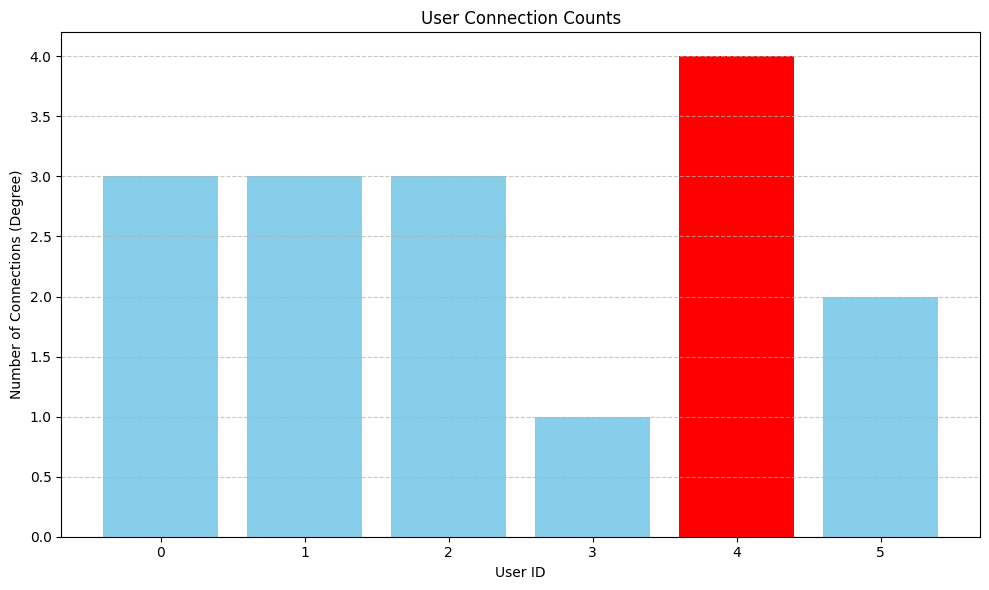

In [ ]:
degrees = np.sum(A, axis=1)
print("Degrees of each user:")
for i in range(N):
    print(f"User {i}: {degrees[i]} connections")
max_connections_user = np.argmax(degrees)
max_connections = degrees[max_connections_user]
print(f"\nUser {max_connections_user} has the largest number of connections: {max_connections}")
plt.figure(figsize=(10, 6))
plt.bar(range(N), degrees, color='skyblue')
plt.title('User Connection Counts')
plt.xlabel('User ID')
plt.ylabel('Number of Connections (Degree)')
plt.xticks(range(N))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.bar(max_connections_user, degrees[max_connections_user], color='red')
plt.tight_layout()
plt.show()

## 3. Matrix of Paths of Length 2

We'll compute A² (via np.dot) and explain what element A²[i, j] means in the context of the graph.

A² (matrix of paths of length 2):
[[3 3 1 1 1 0]
 [3 3 1 1 1 0]
 [1 1 3 1 2 2]
 [1 1 1 1 0 0]
 [1 1 2 0 4 2]
 [0 0 2 0 2 2]]


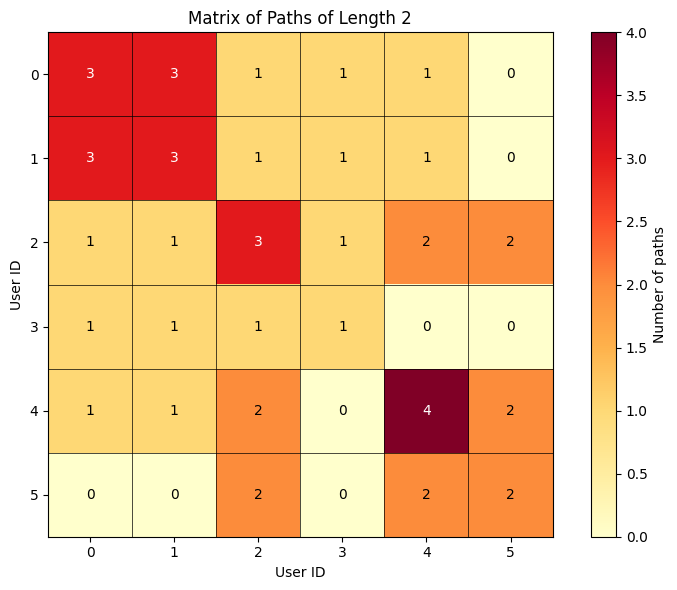

In [ ]:
A_squared = np.dot(A, A)
print("A² (matrix of paths of length 2):")
print(A_squared)
plt.figure(figsize=(8, 6))
plt.imshow(A_squared, cmap='YlOrRd')
plt.colorbar(label='Number of paths')
plt.title('Matrix of Paths of Length 2')
plt.xlabel('User ID')
plt.ylabel('User ID')

for i in range(N):
    plt.axhline(i-0.5, color='black', linewidth=0.5)
    plt.axvline(i-0.5, color='black', linewidth=0.5)

for i in range(N):
    for j in range(N):
        plt.text(j, i, A_squared[i, j], ha='center', va='center', color='black' if A_squared[i, j] < 3 else 'white')
        
plt.xticks(range(N))
plt.yticks(range(N))
plt.tight_layout()
plt.show()

### Explanation of A²[i, j]

In the context of the graph:

- **A²[i, j]** represents the **number of paths of length 2** from user i to user j.
- In other words, it counts how many "friends of friends" connect user i to user j.

For example, if A²[0, 3] = 2, this means there are 2 different users who are friends with both user 0 and user 3. These users serve as "intermediaries" or "common friends" between users 0 and 3.

Mathematically, this is because:
$A^2_{ij} = \sum_{k=0}^{N-1} A_{ik} \times A_{kj}$

Each term in this sum (A[i,k] × A[k,j]) is 1 only when both user i is connected to user k AND user k is connected to user j. So we're counting all the different k's that form a path i → k → j.

The diagonal elements A²[i, i] represent the number of paths of length 2 from a node back to itself, which essentially counts the number of triangles that include node i.

## 4. Indirect Friends

Next, we'll find the number of unique friends-of-friends (not direct friends) for each user. We'll use A² > 0 and boolean masks for this.

Matrix of indirect friends (friends-of-friends but not direct friends):
[[0 0 1 0 0]
 [0 0 0 1 1]
 [1 0 0 0 0]
 [0 1 0 0 1]
 [0 1 0 1 0]]

Number of indirect friends for each user:
User 0: 1 indirect friends
User 1: 2 indirect friends
User 2: 1 indirect friends
User 3: 2 indirect friends
User 4: 2 indirect friends


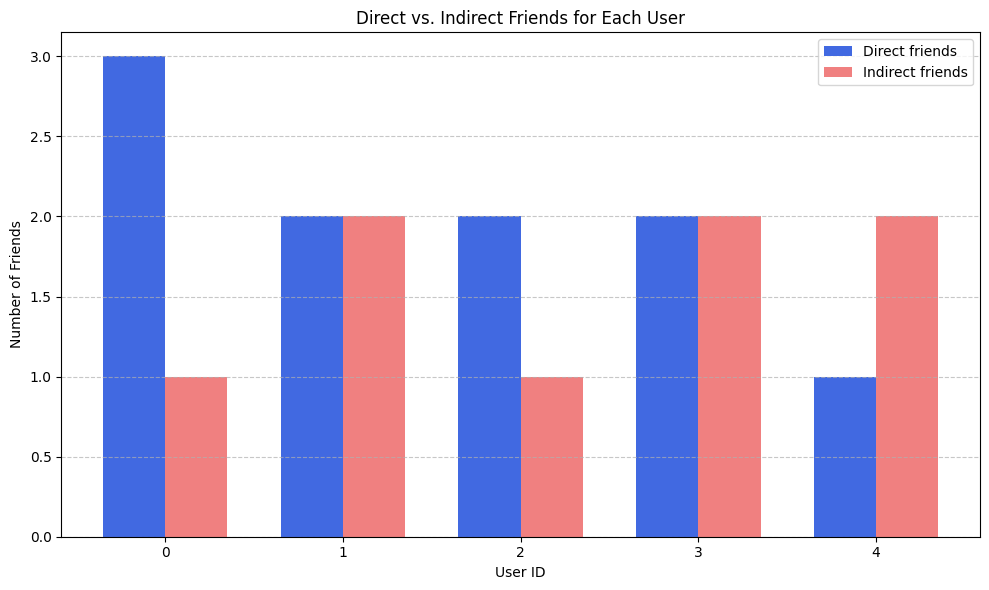


List of indirect friends for each user:
User 0: [2]
User 1: [3, 4]
User 2: [0]
User 3: [1, 4]
User 4: [1, 3]


In [ ]:
potential_indirect_friends = (A_squared > 0).astype(int)
indirect_friends_mask = (potential_indirect_friends > 0) & (A == 0)
np.fill_diagonal(indirect_friends_mask, False)

indirect_friends = indirect_friends_mask.astype(int)
print("Matrix of indirect friends (friends-of-friends but not direct friends):")
print(indirect_friends)

num_indirect_friends = np.sum(indirect_friends, axis=1)
print("\nNumber of indirect friends for each user:")

for i in range(N):
    print(f"User {i}: {num_indirect_friends[i]} indirect friends")
plt.figure(figsize=(10, 6))

x = np.arange(N)
width = 0.35

plt.bar(x - width/2, degrees, width, label='Direct friends', color='royalblue')
plt.bar(x + width/2, num_indirect_friends, width, label='Indirect friends', color='lightcoral')
plt.xlabel('User ID')
plt.ylabel('Number of Friends')
plt.title('Direct vs. Indirect Friends for Each User')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

indirect_friend_lists = []
for i in range(N):
    indirect_friend_lists.append([j for j in range(N) if indirect_friends[i, j] == 1])
print("\nList of indirect friends for each user:")
for i in range(N):
    print(f"User {i}: {indirect_friend_lists[i]}")

## 5. Eigenvalues

Finally, we'll find the eigenvalues of the adjacency matrix and identify the spectral radius (the largest absolute eigenvalue).

Eigenvalues of the adjacency matrix:
[-2.13577921  2.13577921 -0.66215345  0.66215345  0.        ]

Spectral radius: 2.1357792050698556


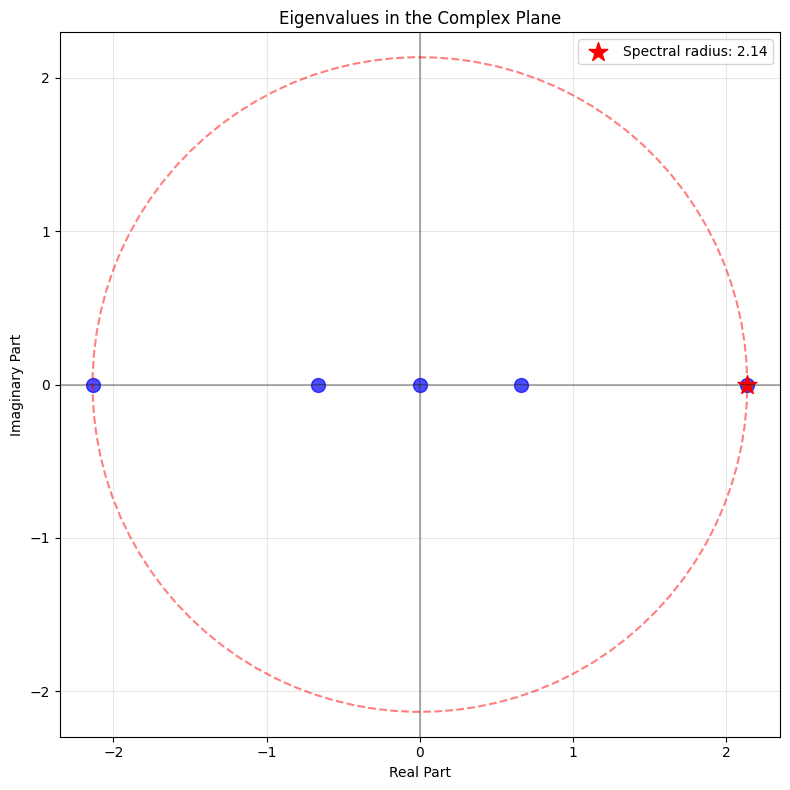

In [ ]:
eigenvalues = np.linalg.eigvals(A)

print("Eigenvalues of the adjacency matrix:")
print(eigenvalues)

spectral_radius = np.max(np.abs(eigenvalues))
print(f"\nSpectral radius: {spectral_radius}")
plt.figure(figsize=(8, 8))
plt.scatter(eigenvalues.real, eigenvalues.imag, s=100, c='blue', alpha=0.7)

max_idx = np.argmax(np.abs(eigenvalues))
plt.scatter(eigenvalues.real[max_idx], eigenvalues.imag[max_idx], s=200, c='red', marker='*', label=f'Spectral radius: {spectral_radius:.2f}')
theta = np.linspace(0, 2*np.pi, 100)
x = spectral_radius * np.cos(theta)
y = spectral_radius * np.sin(theta)

plt.plot(x, y, 'r--', alpha=0.5)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.grid(alpha=0.3)
plt.title('Eigenvalues in the Complex Plane')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we worked with a graph representation using adjacency matrices. We:

1. **Created an adjacency matrix** for a simple friendship graph and made it undirected
2. **Calculated vertex degrees** to find the most connected users
3. **Computed A²** and explained how it represents the number of paths of length 2
4. **Found indirect friends** using boolean masks and the A² matrix
5. **Analyzed eigenvalues** and identified the spectral radius

These matrix operations on graphs are fundamental in network analysis, recommendation systems, and many other applications of graph theory in data science.